In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Load Dataset
df = pd.read_csv("F:/OneDrive - University of Hertfordshire/DS Project/imdb_movie_dataset.csv")

In [4]:
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [5]:
df.shape

(1000, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


In [7]:
df.isnull().sum()

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64

In [8]:
# Drop missing target rows
df = df.dropna(subset=['Revenue (Millions)'])

In [9]:
# Impute 'Metascore'
imputer = SimpleImputer(strategy='mean')
df['Metascore'] = imputer.fit_transform(df[['Metascore']])

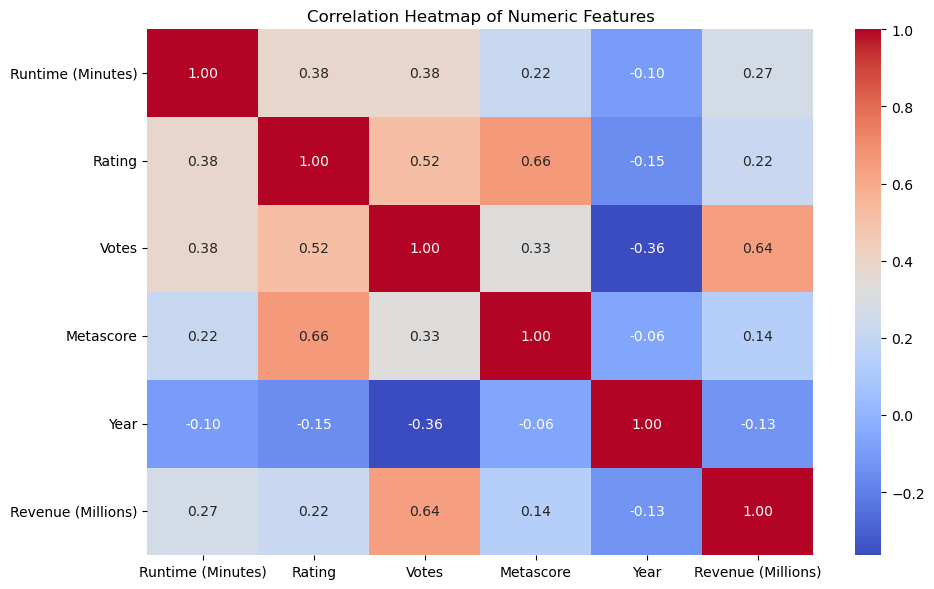

In [10]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year', 'Revenue (Millions)']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

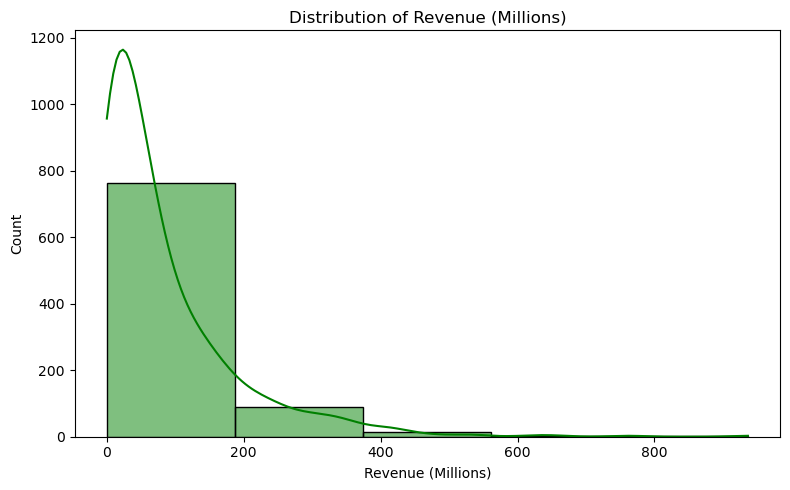

In [11]:
# Distribution of Revenue
plt.figure(figsize=(8, 5))
sns.histplot(df['Revenue (Millions)'], bins=5, kde=True, color='green')
plt.title("Distribution of Revenue (Millions)")
plt.xlabel("Revenue (Millions)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [12]:
# Feature Engineering
df['MainGenre'] = df['Genre'].apply(lambda x: x.split(',')[0])

In [13]:
top_directors = df['Director'].value_counts().nlargest(10).index
df['TopDirector'] = df['Director'].apply(lambda x: x if x in top_directors else 'Other')

In [14]:
df['LeadActor'] = df['Actors'].apply(lambda x: x.split(',')[0])
top_actors = df['LeadActor'].value_counts().nlargest(10).index
df['TopActor'] = df['LeadActor'].apply(lambda x: x if x in top_actors else 'Other')

In [15]:
# Select Features
features = ['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year', 'MainGenre', 'TopDirector', 'TopActor']
X = df[features]
y = df['Revenue (Millions)']

In [16]:
categorical = ['MainGenre', 'TopDirector', 'TopActor']
numerical = ['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year']

In [17]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

In [18]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

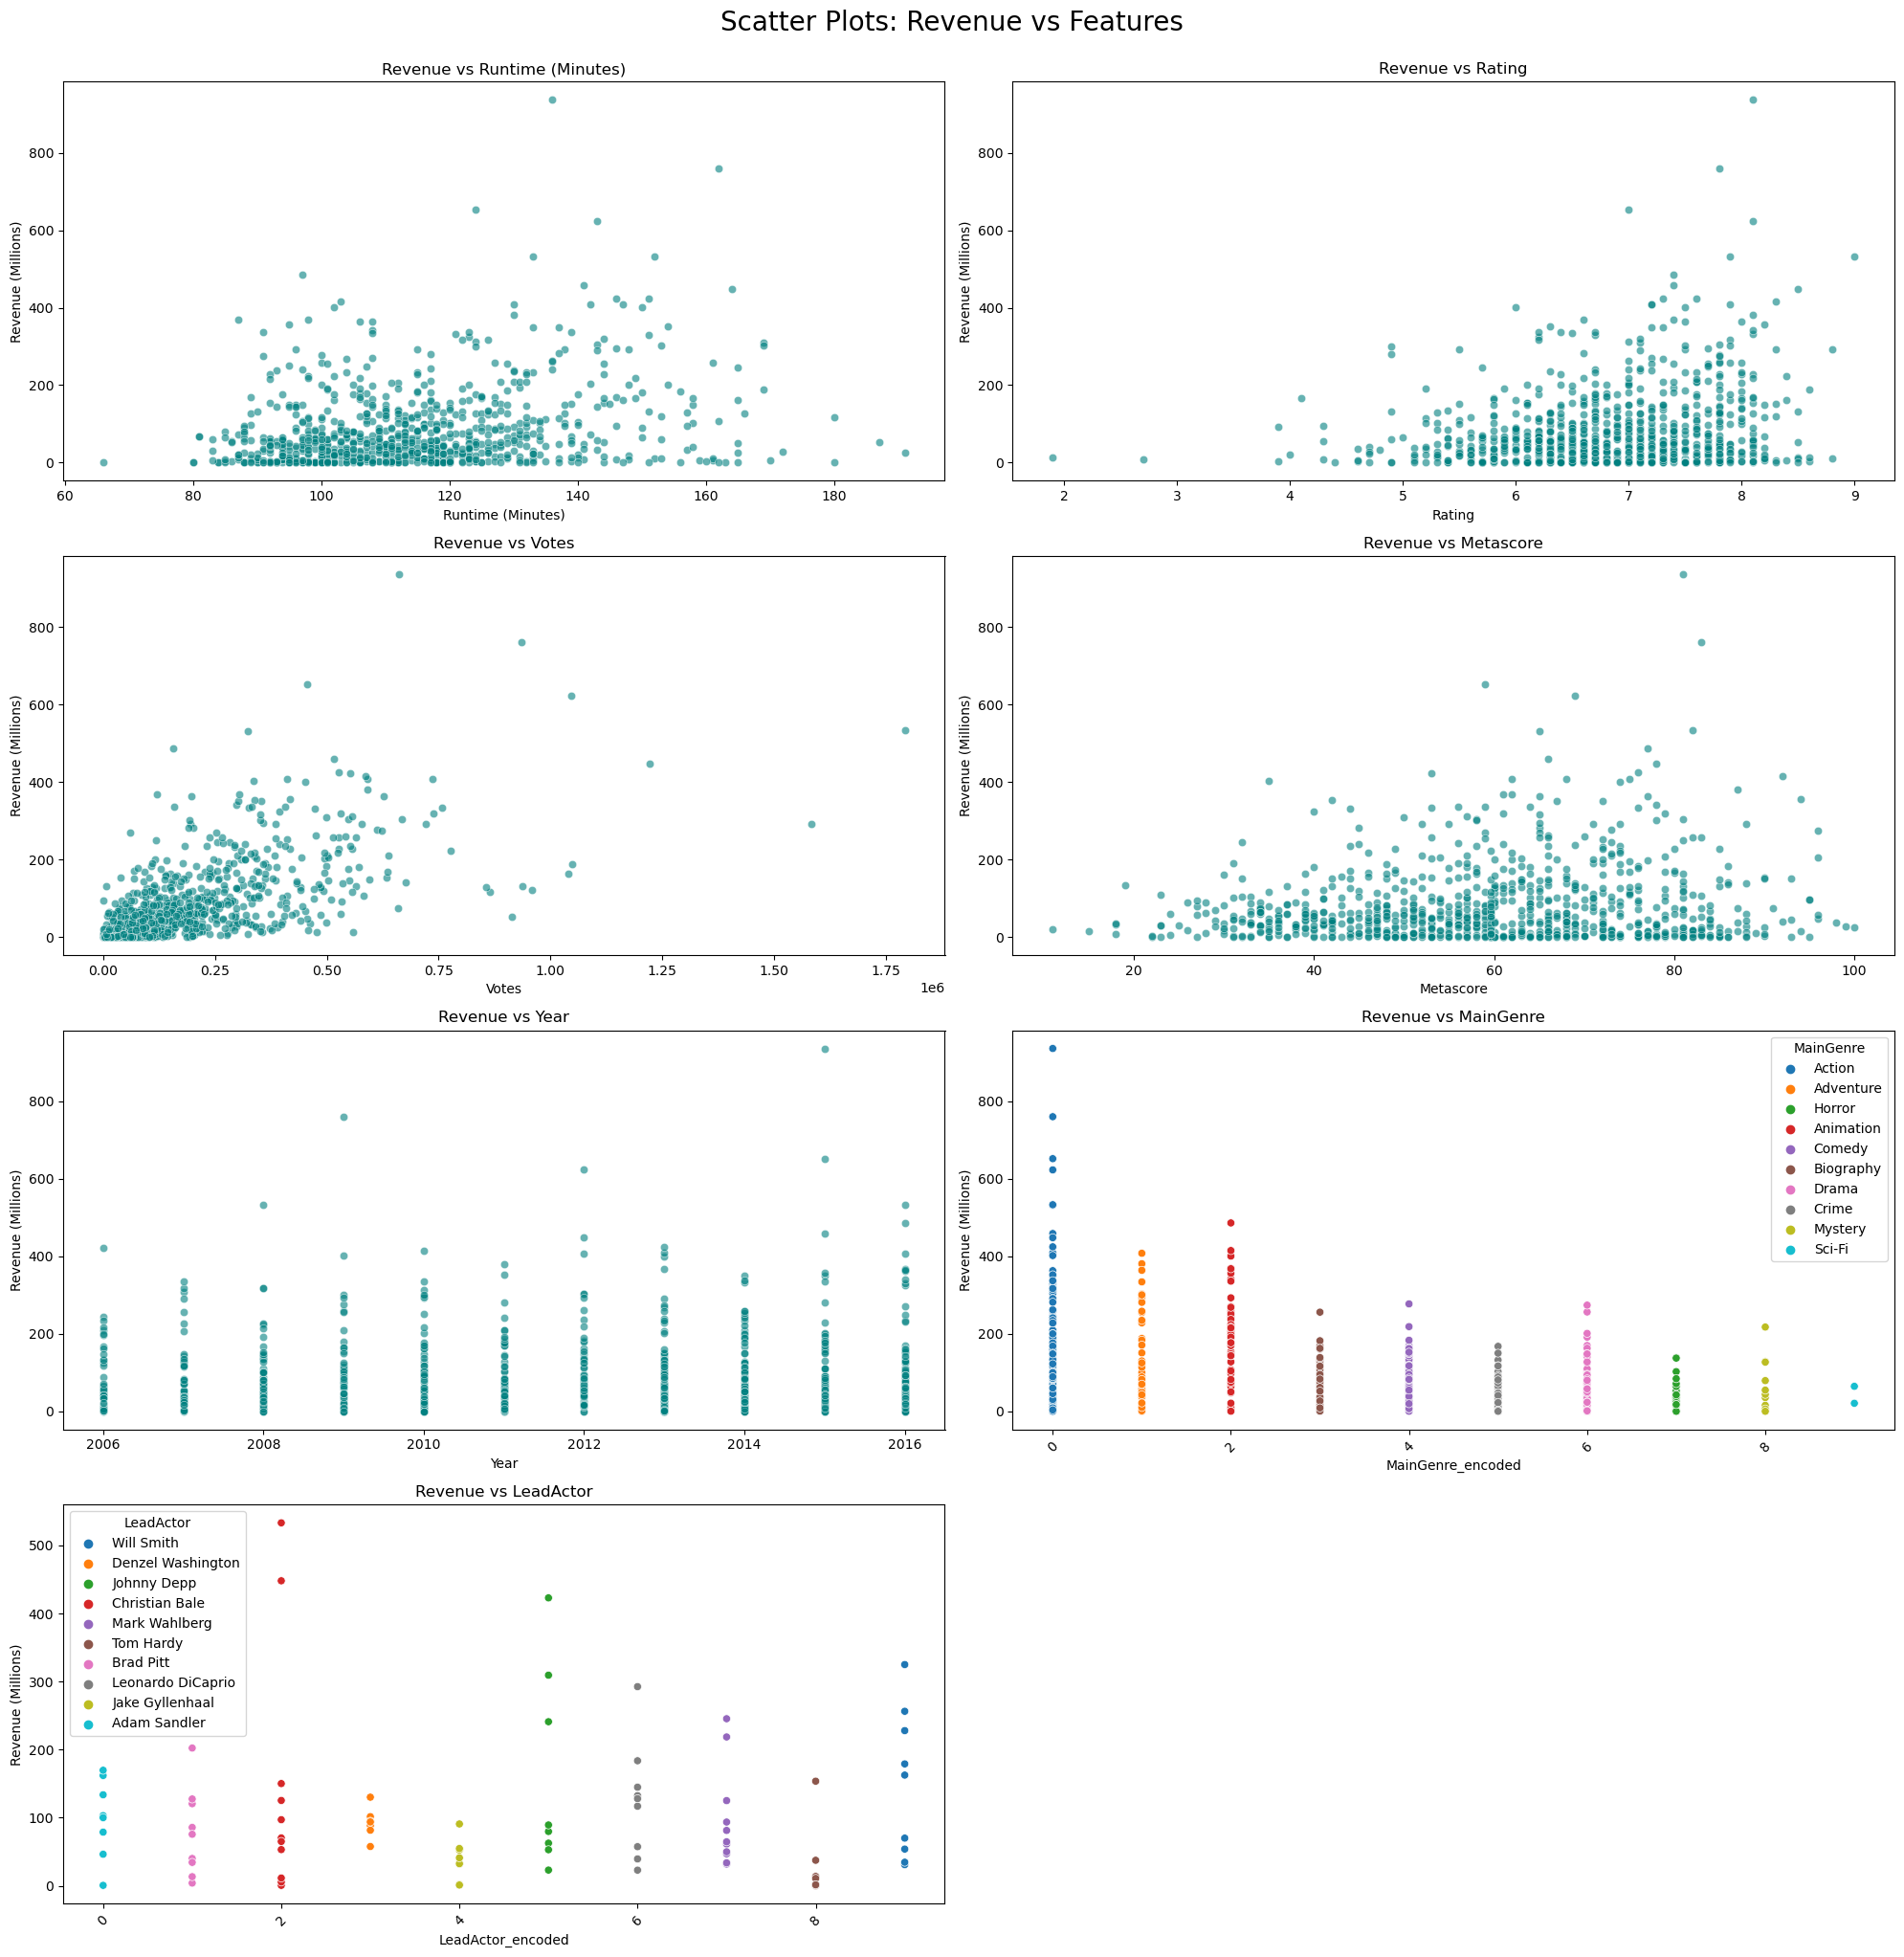

In [19]:
# Columns to compare
columns_to_compare = [
    'Runtime (Minutes)', 'Rating', 'Votes',
    'Metascore', 'Year', 'MainGenre', 'LeadActor', 
]

# Create scatter plots
plt.figure(figsize=(20, 20))
for i, col in enumerate(columns_to_compare, 1):
    plt.subplot(4, 2, i)

    if df[col].dtype == 'object':
        # Encode top 10 categories with numeric values for scatter plot
        top_values = df[col].value_counts().nlargest(10).index
        df_filtered = df[df[col].isin(top_values)].copy()
        df_filtered[col + '_encoded'] = df_filtered[col].astype('category').cat.codes
        sns.scatterplot(data=df_filtered, x=col + '_encoded', y='Revenue (Millions)', hue=col, palette='tab10')
        plt.xticks(rotation=45)
    else:
        sns.scatterplot(data=df, x=col, y='Revenue (Millions)', alpha=0.6, color='teal')

    plt.title(f'Revenue vs {col}')
    plt.tight_layout()

plt.suptitle("Scatter Plots: Revenue vs Features", fontsize=20, y=1.02)
plt.show()


# Linear Regression

In [20]:

model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_lr))

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

print("R2 Score:", r2_score(y_test, y_pred_lr))

MAE: 52.2513109635244
RMSE: 81.96511261394295
R2 Score: 0.48519481361374805


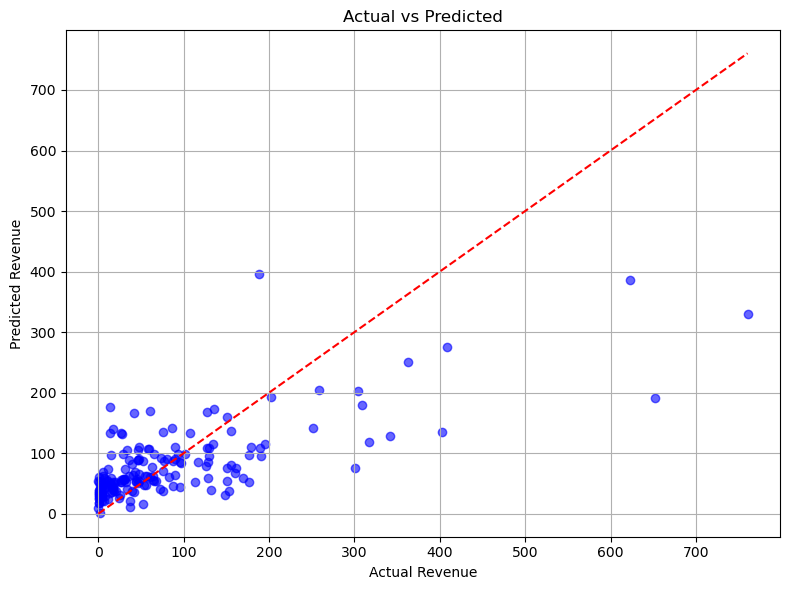

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

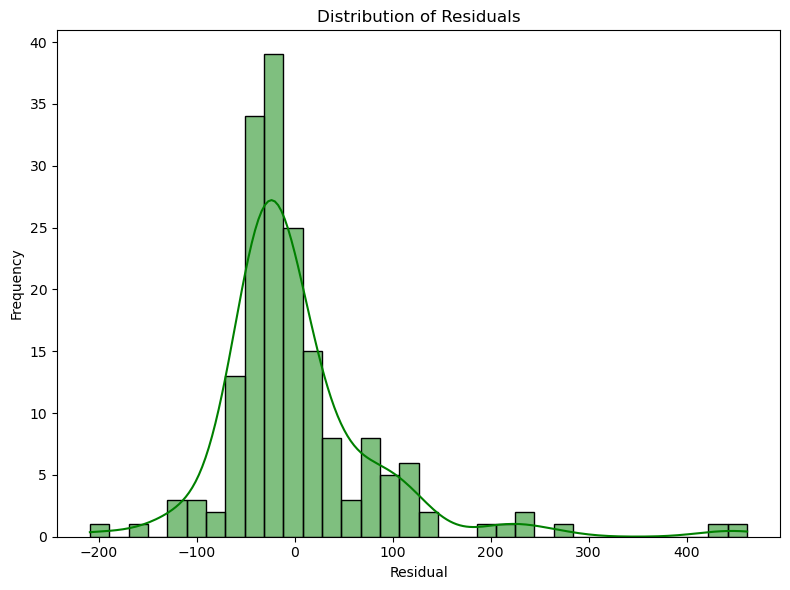

In [22]:
plt.figure(figsize=(8, 6))
residuals = y_test - y_pred_lr
sns.histplot(residuals, kde=True, color='green')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [47]:

coefficients = model_lr.named_steps['model'].coef_
feature_names = model_lr.named_steps['preprocessor'].get_feature_names_out()

importance_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance_df_lr.head(10))


                            Feature  Coefficient
39                  remainder__Year     4.609596
2          cat__MainGenre_Animation     0.919310
6              cat__MainGenre_Drama    -0.828941
36                remainder__Rating    -0.761669
0             cat__MainGenre_Action     0.706922
38             remainder__Metascore    -0.387419
5              cat__MainGenre_Crime    -0.383967
32              cat__TopActor_Other     0.310560
4             cat__MainGenre_Comedy    -0.238896
30  cat__TopActor_Leonardo DiCaprio    -0.203146


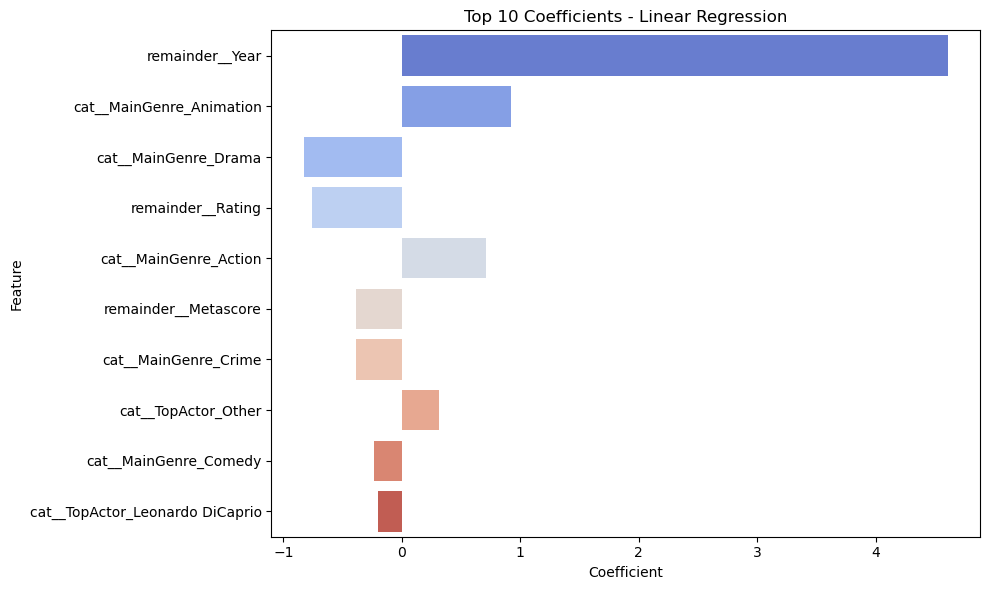

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_lr.head(10), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Coefficients - Linear Regression')
plt.tight_layout()
plt.show()

# Decision Tree

In [30]:
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42, max_depth=5))
])
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_dt))

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))

print("R² Score:", r2_score(y_test, y_pred_dt))

MAE: 49.466975419456816
RMSE: 83.62849394970176
R² Score: 0.46408811917842585


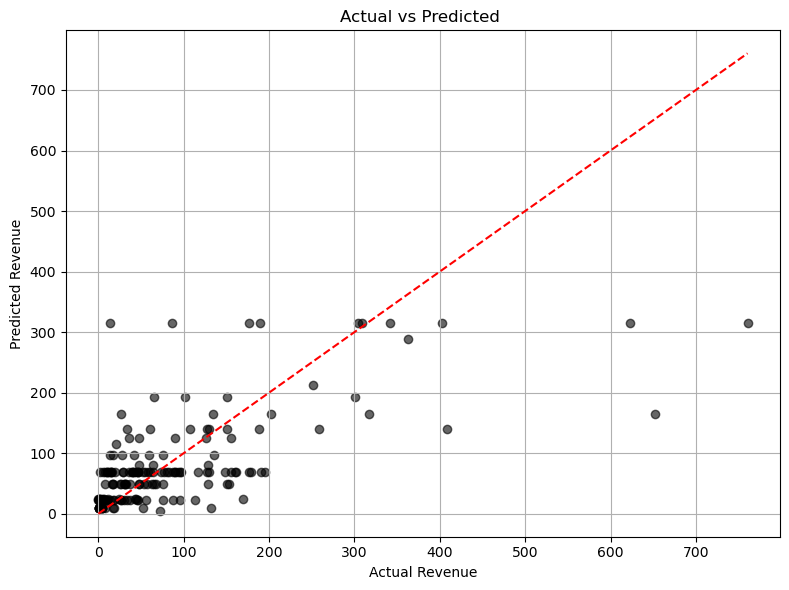

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_dt, color='black', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted ')
plt.grid(True)
plt.tight_layout()
plt.show()

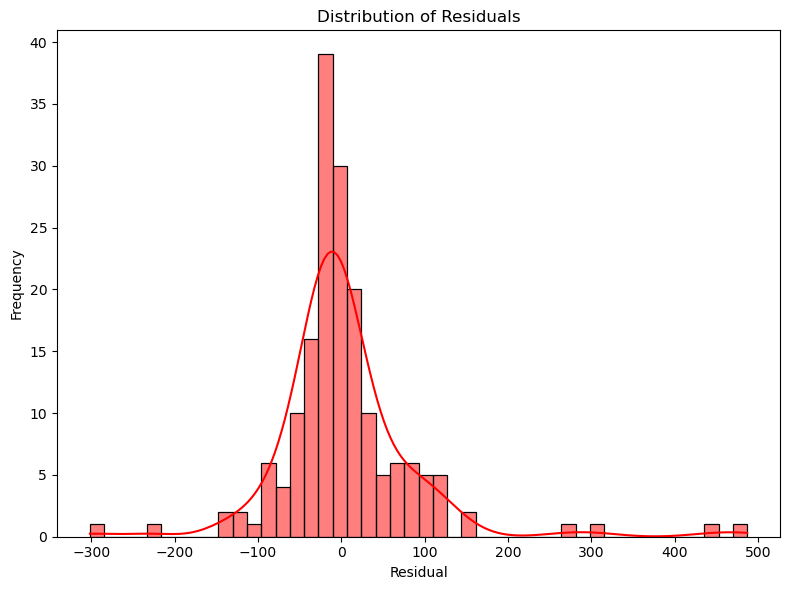

In [32]:
residuals_dt = y_test - y_pred_dt
plt.figure(figsize=(8, 6))
sns.histplot(residuals_dt, kde=True, color='red')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [33]:
importances = model_dt.named_steps['model'].feature_importances_
feature_names = model_dt.named_steps['preprocessor'].get_feature_names_out()

importance_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df_dt.head(10))

                         Feature  Importance
37              remainder__Votes    0.572292
2       cat__MainGenre_Animation    0.104453
15  cat__TopDirector_J.J. Abrams    0.090011
0          cat__MainGenre_Action    0.079771
35  remainder__Runtime (Minutes)    0.057492
39               remainder__Year    0.036039
36             remainder__Rating    0.032094
14  cat__TopDirector_David Yates    0.012155
26  cat__TopActor_Christian Bale    0.010720
38          remainder__Metascore    0.004970


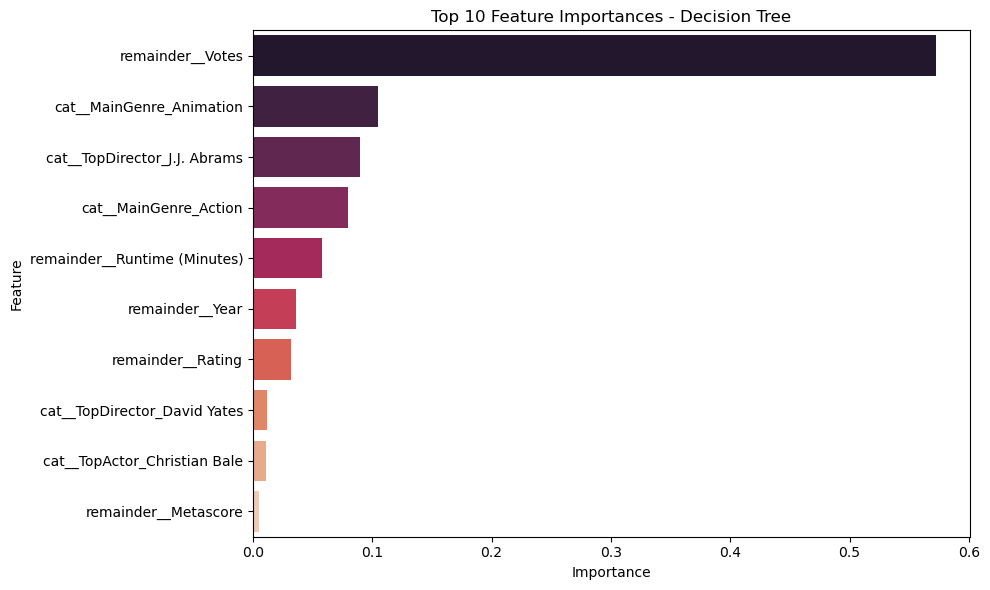

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_dt.head(10), x='Importance', y='Feature', palette='rocket')
plt.title('Top 10 Feature Importances - Decision Tree')
plt.tight_layout()
plt.show()

# Random Forest

In [34]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
])
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_rf))

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

print("R² Score:", r2_score(y_test, y_pred_rf))

MAE: 41.53604127120411
RMSE: 74.15361451749624
R² Score: 0.5786437078307785


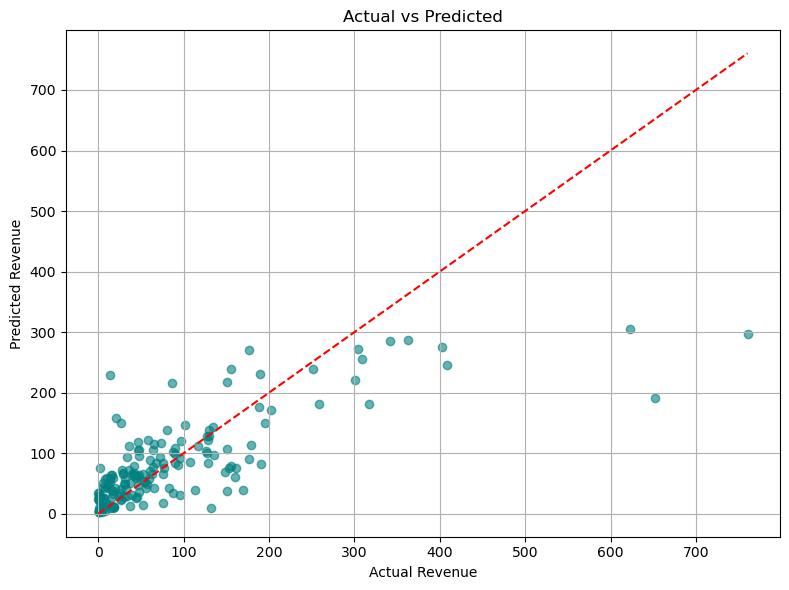

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='teal', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


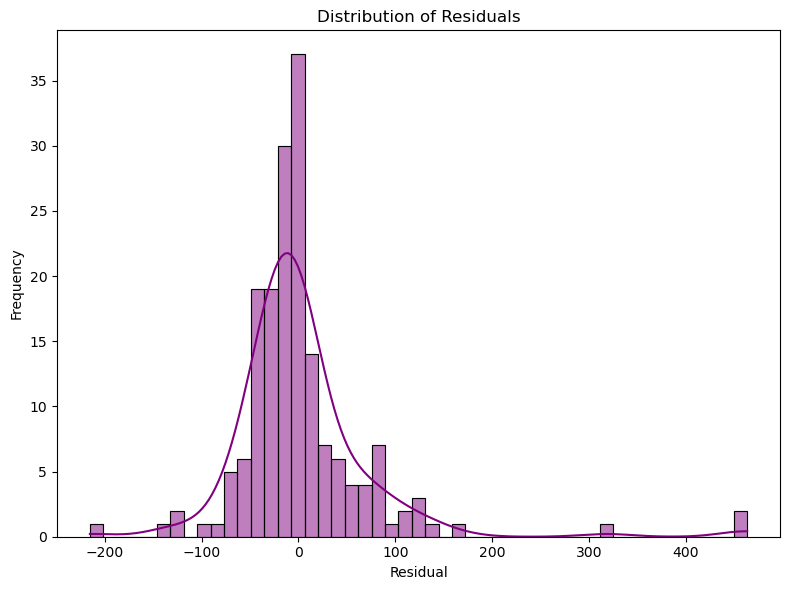

In [36]:
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [37]:
importances = model_rf.named_steps['model'].feature_importances_
feature_names = model_rf.named_steps['preprocessor'].get_feature_names_out()

importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df_rf.head(10))

                         Feature  Importance
37              remainder__Votes    0.514159
2       cat__MainGenre_Animation    0.083992
35  remainder__Runtime (Minutes)    0.073794
36             remainder__Rating    0.073204
39               remainder__Year    0.071672
38          remainder__Metascore    0.046120
15  cat__TopDirector_J.J. Abrams    0.042567
0          cat__MainGenre_Action    0.034680
1       cat__MainGenre_Adventure    0.013786
14  cat__TopDirector_David Yates    0.010829


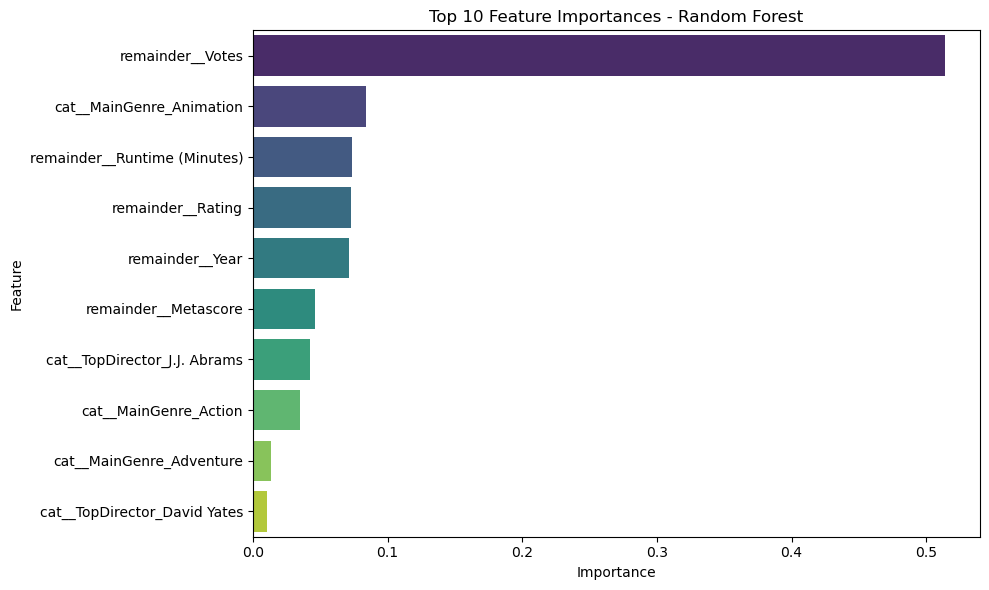

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

# XGBoost

In [38]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred_xgb))

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

print("R² Score:", r2_score(y_test, y_pred_xgb))

MAE: 40.62607203862327
RMSE: 67.40837378091702
R² Score: 0.6518130148316355


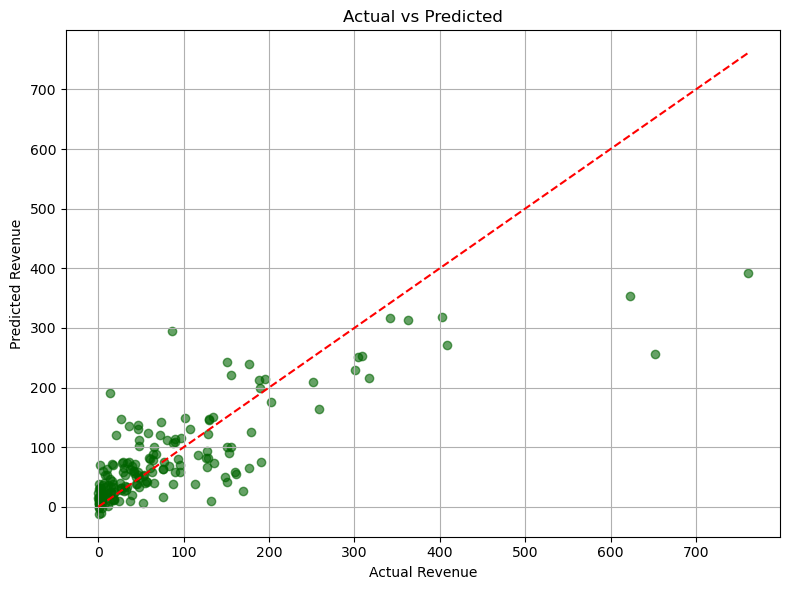

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='darkgreen', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

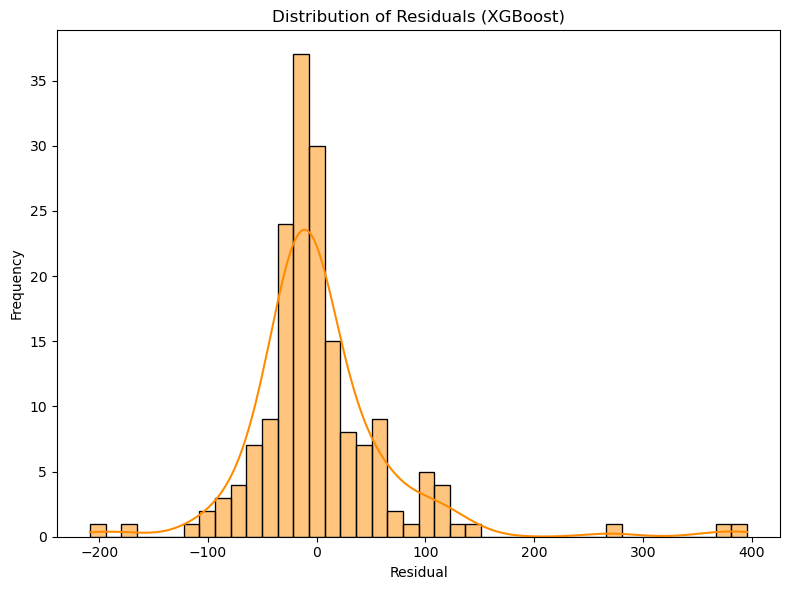

In [40]:
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuals_xgb, kde=True, color='darkorange')
plt.title('Distribution of Residuals (XGBoost)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [41]:
importances = model_xgb.named_steps['model'].feature_importances_
feature_names = model_xgb.named_steps['preprocessor'].get_feature_names_out()

importance_df_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df_xgb.head(10))

                         Feature  Importance
2       cat__MainGenre_Animation    0.107964
37              remainder__Votes    0.101635
14  cat__TopDirector_David Yates    0.091882
0          cat__MainGenre_Action    0.085600
19        cat__TopDirector_Other    0.068164
34      cat__TopActor_Will Smith    0.062730
29     cat__TopActor_Johnny Depp    0.059036
15  cat__TopDirector_J.J. Abrams    0.052459
1       cat__MainGenre_Adventure    0.035712
5           cat__MainGenre_Crime    0.032417


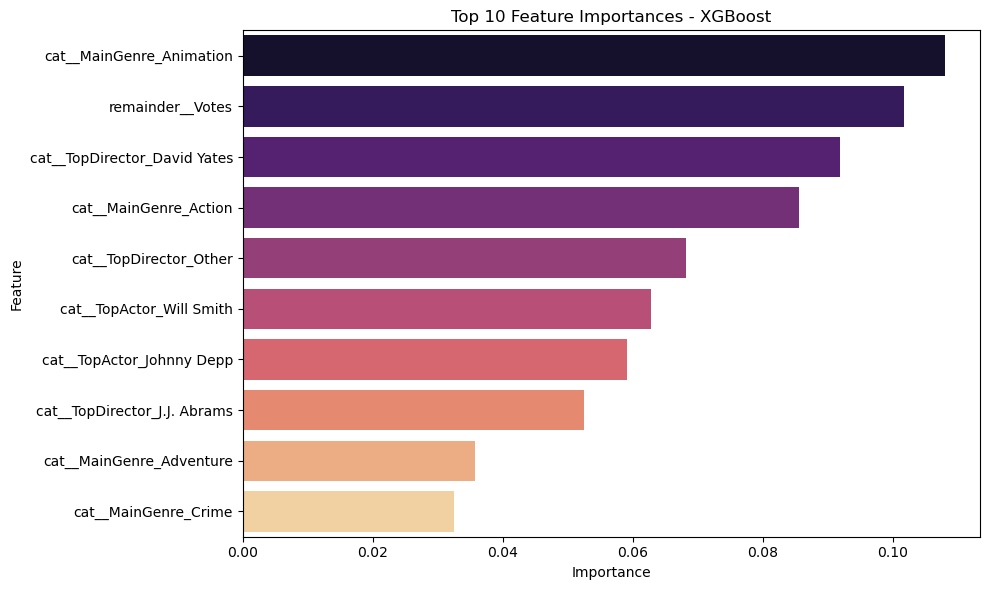

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_xgb.head(10), x='Importance', y='Feature', palette='magma')
plt.title('Top 10 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()